Loading DICOM slices: 100%|█████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 498.84it/s]


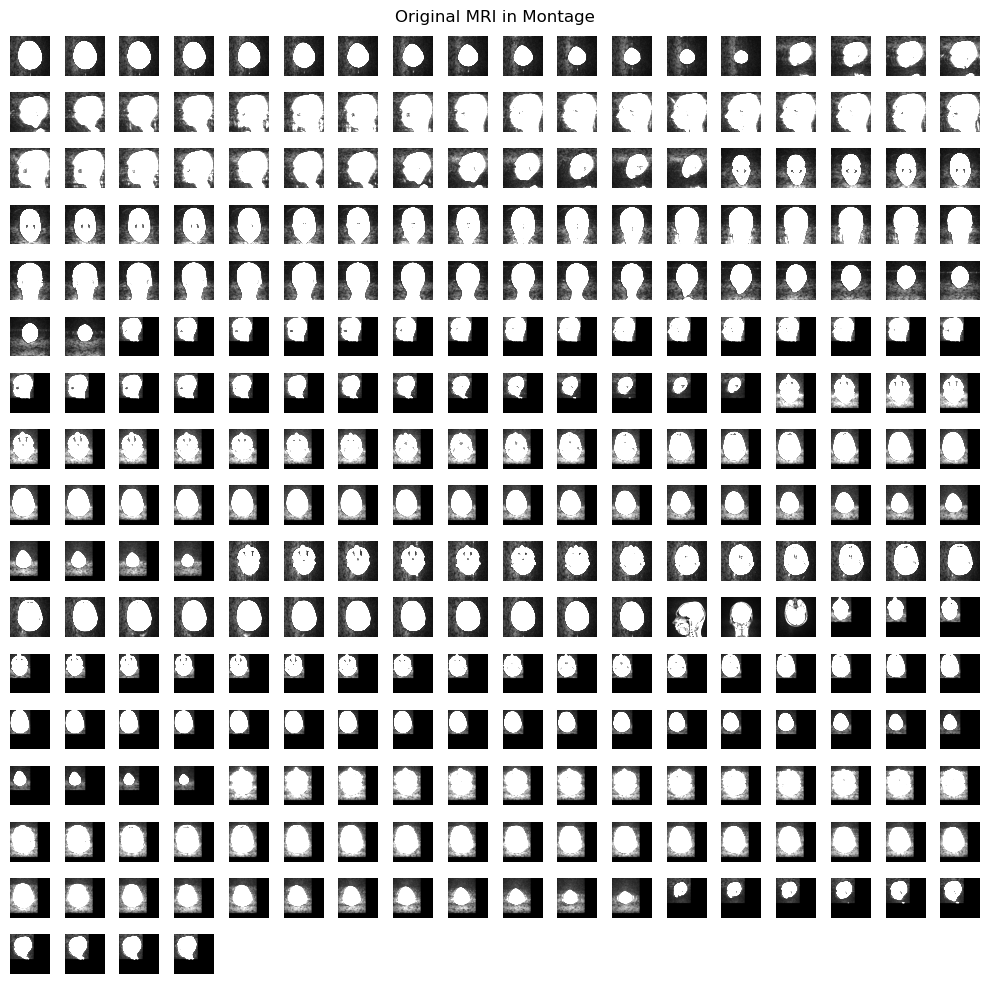

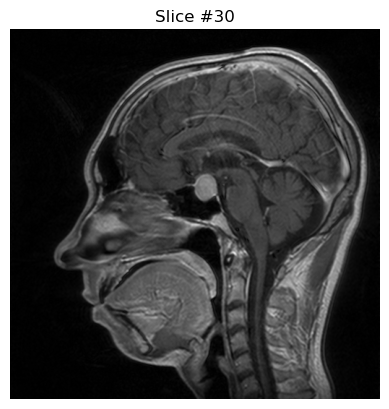

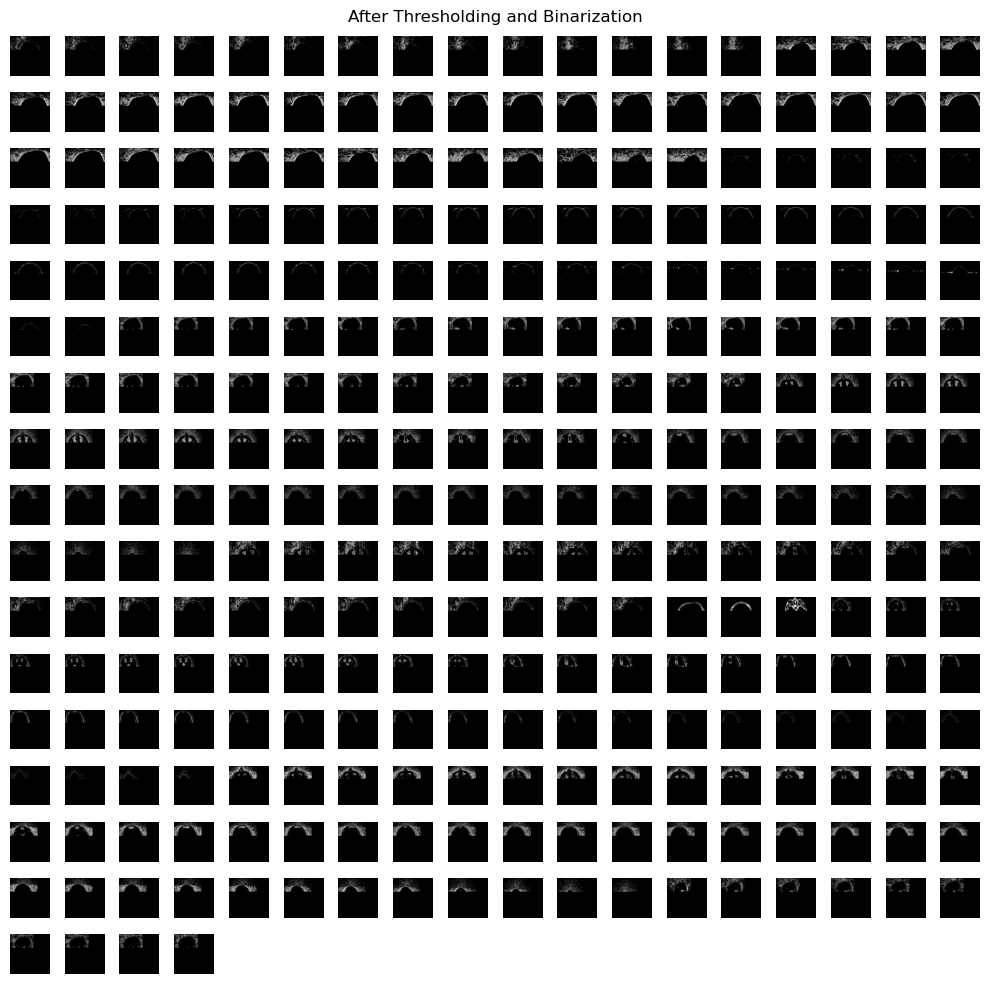

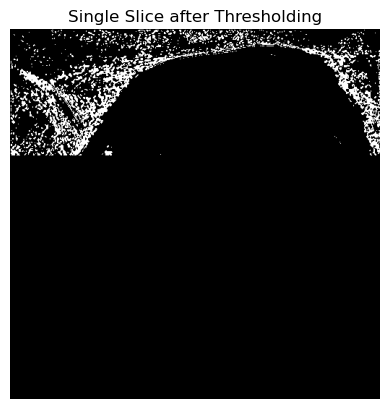

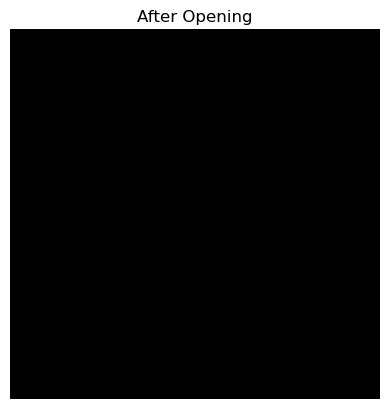

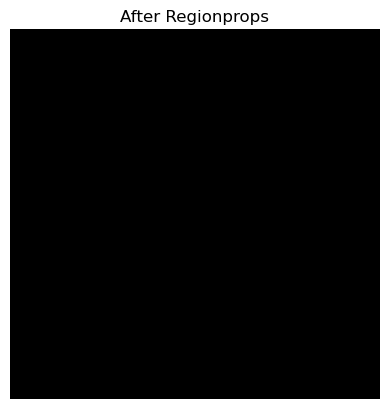

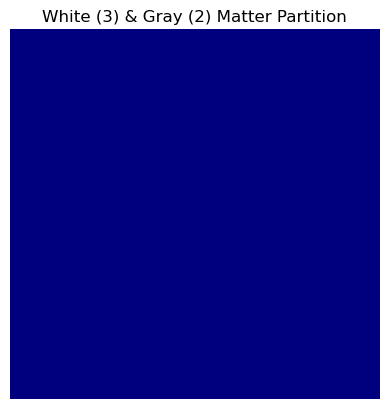

Пропускаем уровень 2.5: вне диапазона [3.00, 3.00]
Пропускаем уровень 1.5: вне диапазона [3.00, 3.00]


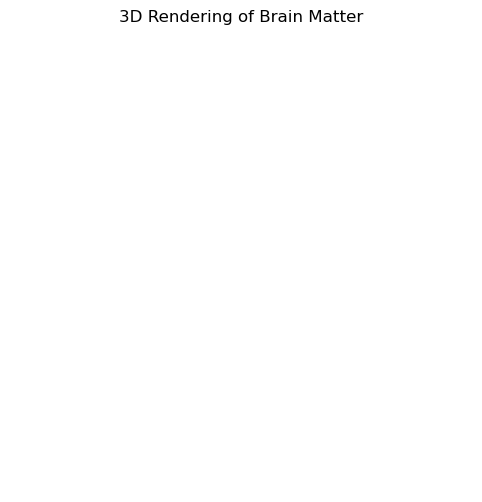

In [18]:
import os
import sys
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage import filters, morphology, measure
from skimage.transform import downscale_local_mean
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Параметры — укажите здесь путь к папке с вашими «сырыми» DICOM-файлами
DATA_PATH = r"E:\dicom dataset\1Р\DICOM\11101015\12160000"    # замените на реальный путь
TH_LOW, TH_HIGH = 40, 100
SLICE_TO_VIEW = 30

# 1. Собираем все файлы (не папки) и сортируем их
all_entries = [os.path.join(DATA_PATH, name) for name in os.listdir(DATA_PATH)]
file_paths = sorted(p for p in all_entries if os.path.isfile(p))
if not file_paths:
    print(f"Ошибка: в папке {DATA_PATH} нет файлов.")
    sys.exit(1)

# 2. Читаем DICOM-файлы и собираем их в список
imgs = []
voxel_size = None
for path in tqdm(file_paths, desc="Loading DICOM slices"):
    try:
        ds = pydicom.dcmread(path)
        arr = ds.pixel_array
    except Exception:
        continue  # пропускаем файлы без пиксельных данных

    if voxel_size is None:
        px_spacing = ds.PixelSpacing       # [row_spacing, col_spacing]
        sl_thick = ds.SliceThickness
        voxel_size = np.array([px_spacing[0], px_spacing[1], sl_thick])

    imgs.append(arr.astype(np.uint16))

if not imgs:
    print("Ошибка: не найдено ни одного DICOM-файла с пиксельными данными.")
    sys.exit(1)

# 3. Выравниваем размеры изображений (pad до максимального)
shapes = np.array([img.shape for img in imgs])
max_h, max_w = shapes[:,0].max(), shapes[:,1].max()
padded = []
for img in imgs:
    h, w = img.shape
    pad_h, pad_w = max_h - h, max_w - w
    padded_img = np.pad(img, ((0,pad_h),(0,pad_w)), mode='constant', constant_values=0)
    padded.append(padded_img)

# 4. Формируем 3D-массив
volume = np.stack(padded, axis=-1)  # (max_h, max_w, N)

# 5. Функция для отображения монтажа
def show_montage(vol, clim=None, title=None):
    n = vol.shape[-1]
    cols = int(np.ceil(np.sqrt(n)))
    rows = int(np.ceil(n / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    axs = axs.flatten()
    for i, ax in enumerate(axs[:n]):
        if clim:
            ax.imshow(vol[..., i], cmap='gray', vmin=clim[0], vmax=clim[1])
        else:
            ax.imshow(vol[..., i], cmap='gray')
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# 6. Показываем оригинальный том
show_montage(volume, clim=(0, 100), title='Original MRI in Montage')

# 7. Отдельный срез
slice_img = volume[:, :, SLICE_TO_VIEW]
plt.figure()
plt.imshow(slice_img, cmap='gray', vmin=0, vmax=slice_img.max())
plt.title(f'Slice #{SLICE_TO_VIEW}')
plt.axis('off')
plt.show()

# 8. Пороговая сегментация
bw = np.logical_and(volume > TH_LOW, volume < TH_HIGH)
bw[175:, :, :] = False

show_montage(bw.astype(np.uint8), title='After Thresholding and Binarization')
plt.figure()
plt.imshow(bw[:, :, SLICE_TO_VIEW], cmap='gray')
plt.title('Single Slice after Thresholding')
plt.axis('off')
plt.show()

# 9. Морфологическое открытие (3D)
selem = morphology.ball(3)
bw_open = morphology.opening(bw, selem)

plt.figure()
plt.imshow(bw_open[:, :, SLICE_TO_VIEW], cmap='gray')
plt.title('After Opening')
plt.axis('off')
plt.show()

# 10. Выделение крупнейшего связного компонента
lbl = measure.label(bw_open)
props = measure.regionprops(lbl)

if not props:
    lbl = measure.label(bw)
    props = measure.regionprops(lbl)
    if not props:
        print("Ошибка: нет связанных компонентов для сегментации.")
        sys.exit(1)

areas = [p.area for p in props]
largest_label = props[int(np.argmax(areas))].label
brain_mask = (lbl == largest_label)
segmented = np.where(brain_mask, volume, 0)

plt.figure()
plt.imshow(segmented[:, :, SLICE_TO_VIEW], cmap='gray', vmin=0, vmax=slice_img.max())
plt.title('After Regionprops')
plt.axis('off')
plt.show()

# 11. Разделение белого и серого вещества (Отсу)
otsu_level = filters.threshold_otsu(segmented[:, :, SLICE_TO_VIEW])
partition = np.zeros_like(segmented, dtype=np.uint8)
partition[(segmented > 0) & (segmented < otsu_level)] = 2
partition[segmented >= otsu_level] = 3

plt.figure()
plt.imshow(partition[:, :, SLICE_TO_VIEW], cmap='jet')
plt.title('White (3) & Gray (2) Matter Partition')
plt.axis('off')
plt.show()

# 12. 3D‑рендеринг через marching cubes с проверкой уровней
ds = downscale_local_mean(partition, (2, 2, 1)).astype(np.float32)
ds = np.flip(ds, axis=(0,1))
ds = np.transpose(ds, (2,1,0))

min_val, max_val = ds.min(), ds.max()

def plot_isosurface_safe(data, level, ax, color_rgba):
    if level <= min_val or level >= max_val:
        print(f"Пропускаем уровень {level}: вне диапазона [{min_val:.2f}, {max_val:.2f}]")
        return
    verts, faces, _, _ = measure.marching_cubes(data, level=level)
    mesh = ax.plot_trisurf(
        verts[:, 0] * voxel_size[0],
        verts[:, 1] * voxel_size[1],
        faces, verts[:, 2] * voxel_size[2],
        linewidth=0, antialiased=True
    )
    mesh.set_facecolor(color_rgba)
    mesh.set_edgecolor('none')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
plot_isosurface_safe(ds, level=2.5, ax=ax, color_rgba=(1, 0, 0, 1))
plot_isosurface_safe(ds, level=1.5, ax=ax, color_rgba=(1, 1, 0, 0.5))
ax.view_init(45, 45)
ax.set_box_aspect((1,1,1))
ax.axis('off')
plt.title('3D Rendering of Brain Matter')
plt.show()


Loading DICOM slices: 100%|█████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 512.72it/s]


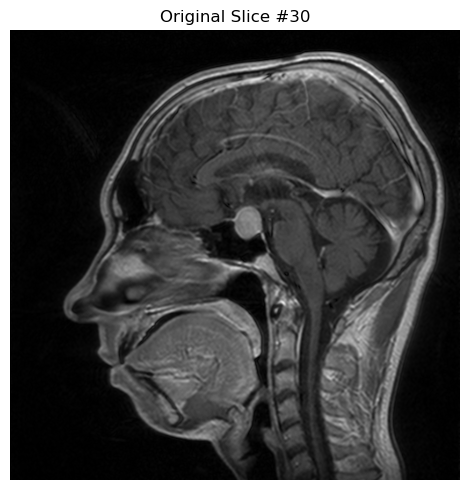

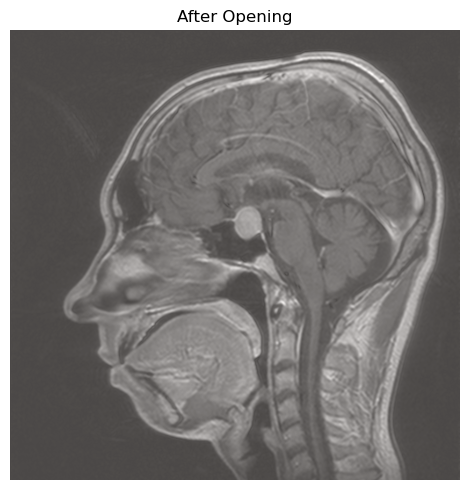

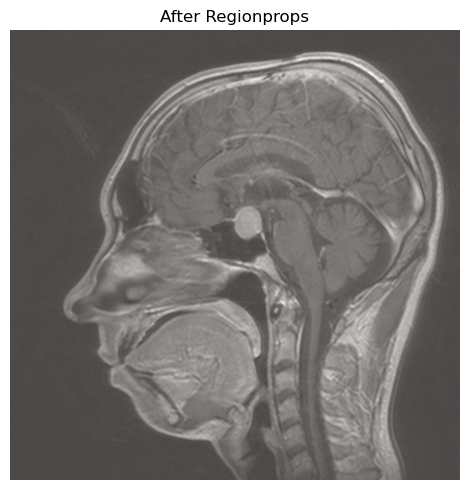

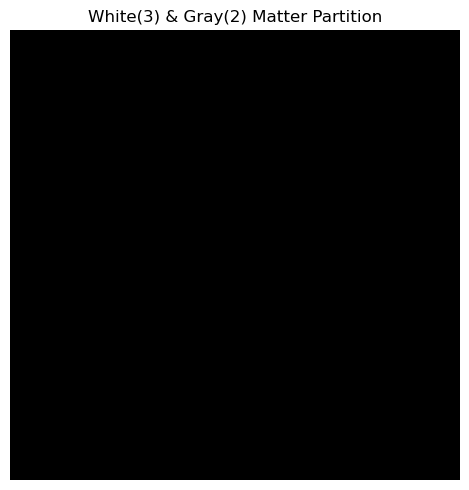

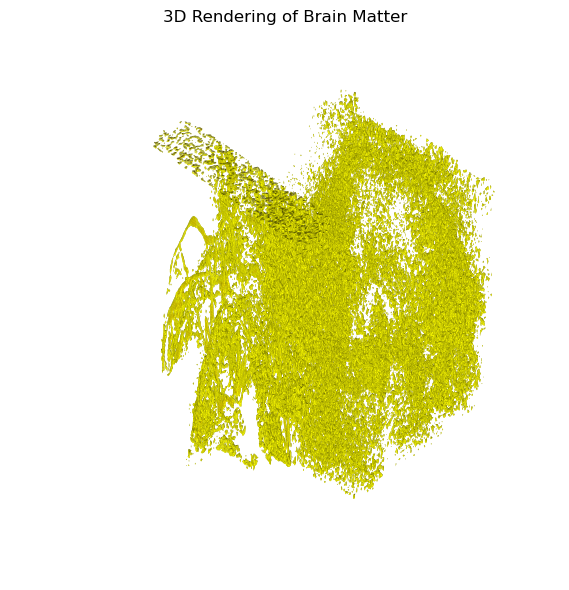

In [20]:
import os
import sys
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage import filters, morphology, measure
from skimage.transform import downscale_local_mean
from mpl_toolkits.mplot3d import Axes3D  # noqa: unused import
from tqdm import tqdm
from matplotlib.colors import ListedColormap

# Параметры
DATA_PATH     = r"E:\dicom dataset\1Р\DICOM\11101015\12160000"   # замените на путь к вашей папке с DICOM-файлами
TH_LOW        = 40
TH_HIGH       = 100
SLICE_TO_VIEW = 30

# 1. Сбор всех файлов в папке
files = sorted(os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH)
               if os.path.isfile(os.path.join(DATA_PATH, f)))
if not files:
    print("Ошибка: не найдено файлов в папке."); sys.exit(1)

# 2. Загрузка DICOM-изображений
imgs = []
voxel_size = None
for p in tqdm(files, desc="Loading DICOM slices"):
    try:
        ds = pydicom.dcmread(p)
        arr = ds.pixel_array
    except Exception:
        continue
    if voxel_size is None:
        px, py = ds.PixelSpacing
        pz = ds.SliceThickness
        voxel_size = np.array([px, py, pz])
    imgs.append(arr.astype(np.uint16))

if not imgs:
    print("Ошибка: ни одного DICOM с пикселями."); sys.exit(1)

# 3. Подгонка размеров (pad) и формирование объёма
h_max = max(im.shape[0] for im in imgs)
w_max = max(im.shape[1] for im in imgs)
padded = [np.pad(im,
                 ((0, h_max-im.shape[0]),
                  (0, w_max-im.shape[1])),
                 mode='constant',
                 constant_values=0)
          for im in imgs]
vol = np.stack(padded, axis=-1)

# Вспомогательные функции
def show_slice(img, title):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray', vmin=0, vmax=img.max())
    plt.title(title); plt.axis('off'); plt.tight_layout(); plt.show()

def show_mask_overlay(img, mask, title):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray', vmin=0, vmax=img.max())
    plt.imshow(mask, cmap='Reds', alpha=0.3)
    plt.title(title); plt.axis('off'); plt.tight_layout(); plt.show()

# 4. Базовый срез
slice0 = vol[:, :, SLICE_TO_VIEW]
show_slice(slice0, f"Original Slice #{SLICE_TO_VIEW}")

# 5. Thresholding
bw = np.logical_and(vol > TH_LOW, vol < TH_HIGH)
bw[175:, :, :] = False

# 6. After Opening
selem = morphology.ball(3)
bw_open = morphology.opening(bw, selem)
show_mask_overlay(slice0, bw_open[:, :, SLICE_TO_VIEW], "After Opening")

# 7. After Regionprops
lbl = measure.label(bw_open)
props = measure.regionprops(lbl)
if not props:
    lbl = measure.label(bw)
    props = measure.regionprops(lbl)
areas = [p.area for p in props]
largest_label = props[int(np.argmax(areas))].label
mask_brain = (lbl == largest_label)
segmented = np.where(mask_brain, vol, 0)
show_mask_overlay(slice0, mask_brain[:, :, SLICE_TO_VIEW], "After Regionprops")

# 8. White vs Gray partition with global fallback
# Собираем все ненулевые значения сегментированного тома
vals = segmented[segmented > 0]
if vals.size == 0:
    print("Предупреждение: нет ненулевых значений для Оцу, пропускаем partition.")
    otsu = None
else:
    otsu = filters.threshold_otsu(vals)

partition3d = np.zeros_like(segmented, dtype=np.uint8)
if otsu is not None:
    partition3d[(segmented > 0) & (segmented < otsu)] = 2
    partition3d[segmented >= otsu] = 3
else:
    # если порог не вычислен, всё содержимое мозга — класс 3
    partition3d[segmented > 0] = 3

# 2D‑визуализация partition
cmap = ListedColormap(['black', 'black', 'blue', 'yellow'])
plt.figure(figsize=(5,5))
plt.imshow(partition3d[:, :, SLICE_TO_VIEW], cmap=cmap, vmin=0, vmax=3)
plt.title("White(3) & Gray(2) Matter Partition")
plt.axis('off'); plt.tight_layout(); plt.show()

# 9. 3D‑рендеринг
ds3 = downscale_local_mean(partition3d, (2,2,1)).astype(np.float32)
ds3 = np.flip(ds3, (0,1))
ds3 = np.transpose(ds3, (2,1,0))
minv, maxv = float(ds3.min()), float(ds3.max())

def plot_iso(data, level, ax, color):
    if not (minv < level < maxv):
        print(f"Level {level} out of [{minv:.2f},{maxv:.2f}], skip")
        return
    verts, faces, _, _ = measure.marching_cubes(data, level=level)
    ax.plot_trisurf(
        verts[:,0] * voxel_size[0],
        verts[:,1] * voxel_size[1],
        verts[:,2] * voxel_size[2],
        triangles=faces,
        color=color,
        linewidth=0
    )

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plot_iso(ds3, 2.5, ax, color='red')
plot_iso(ds3, 1.5, ax, color='yellow')
ax.view_init(45, 45); ax.set_box_aspect((1,1,1)); ax.axis('off')
plt.title("3D Rendering of Brain Matter"); plt.tight_layout(); plt.show()


In [6]:
import os
import numpy as np
import pydicom
import ipyvolume as ipv

# 1) Путь к DICOM
DATA_PATH = r"D:\DIPLOM data\dicom dataset\1П\DICOM\13050311\59150000"

# 2) Читаем и пэдим все срезы до общего размера
files = sorted(os.path.join(DATA_PATH, f)
               for f in os.listdir(DATA_PATH)
               if os.path.isfile(os.path.join(DATA_PATH, f)))
slices = []
for fn in files:
    try:
        ds = pydicom.dcmread(fn)
        arr = ds.pixel_array.astype(np.float32)
        slices.append(arr)
    except:
        pass

# Подгоняем к единому размеру
max_h = max(im.shape[0] for im in slices)
max_w = max(im.shape[1] for im in slices)
padded = [ np.pad(im, ((0,max_h-im.shape[0]), (0,max_w-im.shape[1])),
                  mode='constant', constant_values=0)
           for im in slices ]
volume = np.stack(padded, axis=0)  # (z,y,x)

# 3) Нормализация и удаление NaN/Inf
vol = volume - np.nanmin(volume)
if np.nanmax(vol) > 0:
    vol = vol / np.nanmax(vol)
vol = np.nan_to_num(vol, nan=0.0, posinf=1.0, neginf=0.0)

from skimage import measure
import ipyvolume as ipv

# 4a) извлекаем поверхность методом marching cubes
# level подбираете эмпирически, например 0.5
level = 0.5
verts, faces, normals, values = measure.marching_cubes(vol, level=level)

# 4b) визуализация меша
ipv.figure(width=600, height=600)
# vertices: Nx3, faces: Mx3
x, y, z = verts.T

# Рисуем треугольную сетку
mesh = ipv.plot_trisurf(x, y, z,
                       triangles=faces,
                       color="#cccccc",
                       shader="smooth")
# Включаем интерактивные контролы
ipv.view(azimuth=45, elevation=60, distance=200)
ipv.show()


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [1]:
import ipyvolume as ipv
import numpy as np

x, y, z = np.random.rand(3, 10000)
ipv.figure()
ipv.scatter(x, y, z, marker='sphere', size=1, color="orange")
ipv.show()


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [ ]:
import vtkmodules.all as vtk

# 1) Читаем папку DICOM
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(r"D:\DIPLOM data\dicom dataset\1П\DICOM\13050311\59150000")
reader.Update()

# 2) Marching Cubes по Hounsfield-уровню (например, 500)
contour = vtk.vtkMarchingCubes()
contour.SetInputConnection(reader.GetOutputPort())
contour.SetValue(0, 500)
contour.Update()

# 3) Визуализация
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(contour.GetOutputPort())
mapper.ScalarVisibilityOff()

actor = vtk.vtkActor()
actor.SetMapper(mapper)

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(0.1, 0.1, 0.2)

window = vtk.vtkRenderWindow()
window.AddRenderer(renderer)
window.SetSize(800, 800)

interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(window)

window.Render()
interactor.Start()
